In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns


## Movielens full - EDA
a) Gör en EDA för att förstå datasetet. Inkludera olika slags plots. Begränsa dig inte till frågorna nedan,
utan försök undersöka fler aspekter av datan.

* Jag börjar med att undersöka vad datasetet har för columner med df.head och df.info()
* Samt så har jag läst på "Read me" filen som tillhör datasetet

In [2]:
df_movies= pd.read_csv("Data/ml-latest/movies.csv")
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# Jag tar df.info 
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  86537 non-null  int64 
 1   title    86537 non-null  object
 2   genres   86537 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


In [4]:
df_ratings= pd.read_csv("Data/ml-latest/ratings.csv")


In [5]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33832162 entries, 0 to 33832161
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 1.0 GB


Jag ser att jag behöver splita cellerna så att i genders och film titel delas upp.

In [6]:
# Lägg till en 'year'-kolumn baserad på årtalet i titeln och uppdatera titeln utan årtalet
df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)')
df_movies['title'] = df_movies['title'].str.replace(r'\(\d{4}\)', '').str.strip()

b) Vilka är de 10 filmerna med flest ratings?

In [7]:
# Dela upp 'genres'-kolumnen och explodera den för att ha en rad per genre
df_movies['genres'] = df_movies['genres'].str.split('|')
df_movies = df_movies.explode('genres')

# Utför sammanslagning samt välj kolumner och återställ indexet till 'movieId'
merged_df = pd.merge(df_ratings, df_movies, on='movieId')[['movieId', 'title', 'year', 'genres', 'rating']]
merged_df = merged_df.set_index('movieId').reset_index()

# Gruppera efter filmtitel och räkna antalet betyg för varje film
top_10_movies = merged_df.groupby('title').size().reset_index(name='rating_count') \
                         .sort_values(by='rating_count', ascending=False) \
                         .head(10)

print("De 10 filmerna med flest betyg är:")
print(top_10_movies)


De 10 filmerna med flest betyg är:
                                  title  rating_count
32908                  Inception (2010)        455392
24766               Forrest Gump (1994)        454324
52643               Pulp Fiction (1994)        435024
76042                  Toy Story (1995)        384065
58370                      Shrek (2001)        351174
23600                 Fight Club (1999)        344828
35217              Jurassic Park (1993)        332104
42352                Matrix, The (1999)        321168
39048             Lion King, The (1994)        321054
58573  Silence of the Lambs, The (1991)        305406


c) Beräkna den genomsnittliga ratingen för dessa 10 filmerna med flest ratings.

In [8]:
# Genomsnittlig rating för de 10 filmerna med flest betyg
average_rating_top_10 = merged_df[merged_df['title'].isin(top_10_movies['title'])]['rating'].mean()
print("\nDen genomsnittliga ratingen för dessa 10 filmer är:", average_rating_top_10)


Den genomsnittliga ratingen för dessa 10 filmer är: 4.02364288781951


d) Gör en plot över årtal och antalet filmer representerade i datasetet.

Jag tar filtrerar ut så att ploten bara visar filmer från 1950 och framåt

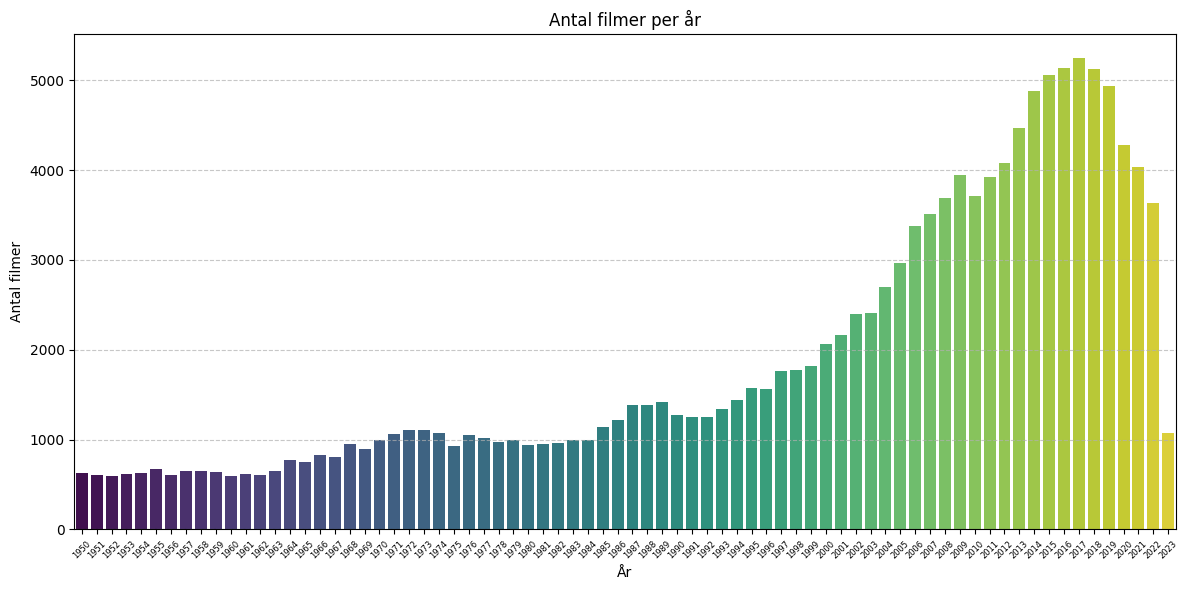

In [9]:
# En ny DataFrame med filtrerade filmer från 1950 och framåt
filtered_movies = df_movies[df_movies['year'].astype(float) >= 1950]

# Gruppera efter årtal och räkna antalet filmer för varje år
movies_per_year = filtered_movies.groupby('year').size().reset_index(name='count')

# Plotta diagrammet med Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=movies_per_year, x='year', y='count', hue='year', palette='viridis', dodge=False, legend=False)
plt.title('Antal filmer per år')
plt.xlabel('År')
plt.ylabel('Antal filmer')
plt.xticks(rotation=45, fontsize=6) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

e) Gör en plot över antalet ratings mot movieId.

In [15]:
import plotly.express as px

# Filtrera bort rader där movieId är 0 från df_ratings
filtered_ratings = df_ratings[df_ratings['movieId'] != 0]

# Beräkna antalet betyg per movieId efter borttagning av rader med movieId 0
ratings_per_movie = filtered_ratings.groupby('movieId').size().reset_index(name='rating_count')

# Plotta antalet betyg per movieId med Plotly Express
fig = px.scatter(ratings_per_movie, x='movieId', y='rating_count', title='Antal betyg per movieId ', labels={'movieId': 'Movie ID', 'rating_count': 'Antal betyg'})
fig.show()

f) Beräkna genomsnittliga ratings för de top 10 filmerna med flest ratings. Gör ett stapeldiagram över
dessa. OBS: Denna deelen är redan gjord och du har sagt att vi inte ska göra den igen ;)

1.2 Skapa gles matris

Likt i videon i uppgift 1.0 skapade du en pivottabell av dataframet med index: "movieId", columns: "userId"
och values: "ratings". Denna pivottabell är dock "dyr" att skapa och förmodligen kommer inte din dator att
klara av skapa den om du inte filtrerar bort viss data. Fundera ut ett lämpligt sätt att filtrera ditt dataset,
pröva dig fram och motivera.#

Skapa en gles (sparse) matris av denna pivottabell mha scipy.sparse.csc_matrix(). Vill du använda
dig av all data går det också att lösa, men du behöver lösa hur du skapar den glesa matrisen utan pandas
pivot-tabell.

 1.3 Recommender system

Skapa ett recommender system med KNN och låt systemet ta input från användaren och skriva ut top 5
rekommenderade filmerna, baserat på användarens sökquery. Observera att det finns ett logiskt fel i
videon som gör att rekommendationerna inte blir så bra, försök hitta felet och åtgärda det.

a) Beskriv med ord hur ditt system fungerar.

b) Leta online och läs vidare om rekommenderarsystem och beskriv kort hur dem fungerar. Glöm inte
källhänvisa.